# Import modules

We start the data processing and visualization by importing necessary modules.

In [ ]:
import os
import pandas as pd
from textblob import TextBlob
import re
import numpy as np
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

import warnings

In [ ]:
# If using Google Colab instead of the Juypyter Notebook interface. Note this means the path for the data to be read in would be different
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Analysis of Transcript of Debates

Again, we will just show how it is done for one debate here, and the input file can be changed for the other debate by changing the path name below. It is the same visualization code for both. 

## Load transcript file and concatenate
There are two parts for the Debate 1. For Debate 2, can just load in the single file on which the transcript has been parsed in from */dataset/parsed_transcript_2.csv*

In [ ]:
transcript_1 = pd.read_csv('/dataset/parsed_transcript_1_1.csv')
transcript_2 = pd.read_csv('/dataset/parsed_transcript_1_2.csv')

In [ ]:
transcript = pd.concat([transcript_1, transcript_2], ignore_index=True)
transcript.head()

,name,time,contents
0,Chris Wallace,00:01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,00:02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,00:02:49,"How you doing, man?"
3,President Donald J. Trump,00:02:51,How are you doing?
4,Vice President Joe Biden,00:02:51,I’m well.


In [ ]:
transcript['totalwords'] = transcript['contents'].str.count(' ') + 1

In [ ]:
data = transcript.groupby(['name'], as_index=False)['totalwords'].sum()
data

,name,totalwords
0,Chris Wallace,4552
1,President Donald J. Trump,7234
2,Vice President Joe Biden,6620


## Use VaderSentiment Package
VaderSentiment gives the score for positivity, negativity, and neutral.
Also, The compound score is computed by summing the score of each word and then normalizing.
We define a function called `vader_polarity` to convert the positivity/negativity/neutral score to ternary value.
-1 if negativity dominates, 0 if neutral dominates, and 1 if positivity dominates.
Also, this function returns a compound score as well.

In [ ]:
analyser = SentimentIntensityAnalyzer()


def vader_polarity(text):
    """
    Transform the output to a -1/0/1
    """
    score = analyser.polarity_scores(text)
    if max(score.values()) == score['pos']:
        return 1, score['compound']
    elif max(score.values()) == score['neu']:
        return 0, score['compound']
    else:
        return -1, score['compound']


## Save computed scores to the new columns

In [ ]:
for index, row in transcript.iterrows():
    text = row['contents']
    transcript.loc[index, 'scores'], transcript.loc[index, 'compound_scores'] = vader_polarity(text)

In [ ]:
transcript.head()

,name,time,contents,totalwords,scores,compound_scores
0,Chris Wallace,00:01:20,Good evening from the Health Education Campus ...,124,0.0,0.8957
1,Chris Wallace,00:02:10,This debate is being conducted under health an...,102,-1.0,0.8661
2,Vice President Joe Biden,00:02:49,"How you doing, man?",4,0.0,0.0000
3,President Donald J. Trump,00:02:51,How are you doing?,4,0.0,0.0000
4,Vice President Joe Biden,00:02:51,I’m well.,2,1.0,0.2732


## Data analysis with the visualization

###Compound Scores Over Time

<function matplotlib.pyplot.show>

<Figure size 1080x504 with 0 Axes>

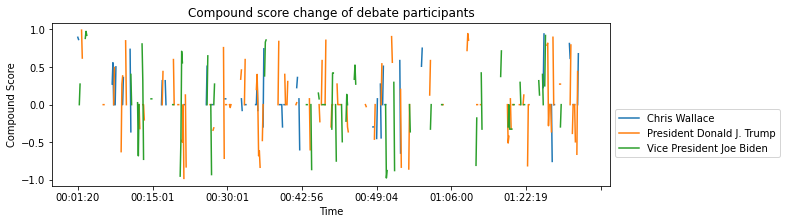

In [ ]:
fig = plt.figure(figsize=(15,7))
pd.pivot_table(transcript.reset_index(),
               index='time', columns='name', values='compound_scores'
              ).plot(figsize=(10,3), subplots=False, legend=True)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
#plt.grid()
plt.title('Compound score change of debate participants')
plt.xlabel('Time')
plt.ylabel('Compound Score')
plt.show

### Compound Scores Over Remarks


Text(0, 0.5, 'Compound Score')

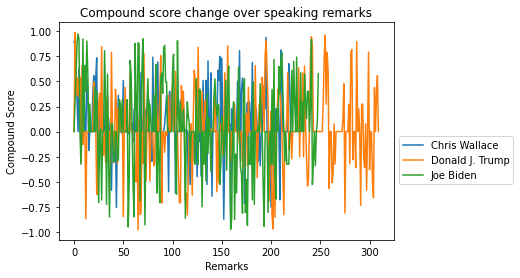

In [ ]:
fig = plt.figure()
compound_score_pivot = pd.pivot_table(transcript.reset_index(), index='time', columns='name', values='compound_scores')
cw = compound_score_pivot['Chris Wallace'].dropna()
plt.plot(cw.to_list())
dt = compound_score_pivot['President Donald J. Trump'].dropna()
plt.plot(dt.to_list())
jb = compound_score_pivot['Vice President Joe Biden'].dropna()
plt.plot(jb.to_list())
plt.legend(['Chris Wallace', 'Donald J. Trump', 'Joe Biden'],
           loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.title('Compound score change over speaking remarks')
plt.xlabel('Remarks')
plt.ylabel('Compound Score')

### Average Compound Scores Over Remarks

Text(0, 0.5, 'Compound Score')

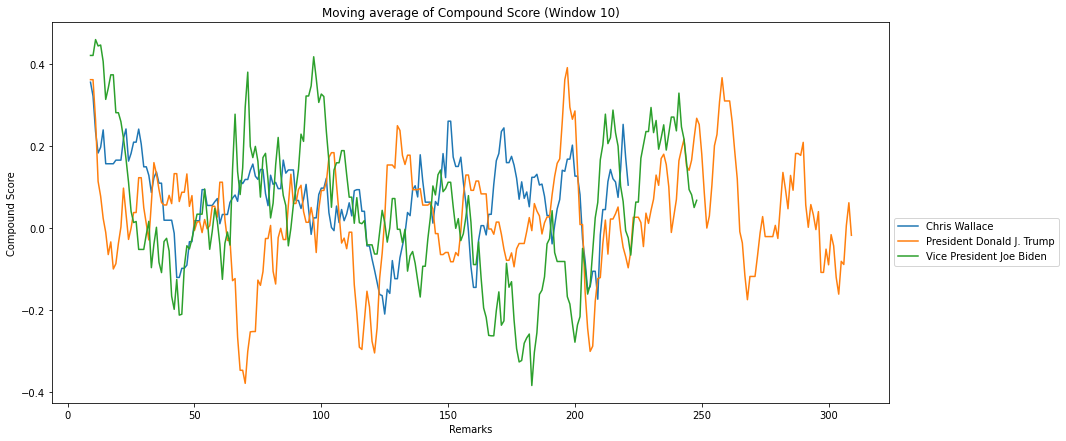

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(cw.rolling(window=10).mean().to_list())
plt.plot(dt.rolling(window=10).mean().to_list())
plt.plot(jb.rolling(window=10).mean().to_list())
plt.legend(['Chris Wallace', 'President Donald J. Trump', 'Vice President Joe Biden'],
           loc='upper left', bbox_to_anchor=(1.0, 0.5))
#plt.grid()
plt.title('Moving average of Compound Score (Window 10)')
plt.xlabel('Remarks')
plt.ylabel('Compound Score')


# Analysis of Tweets: Wordclouds/PieCharts 
We will now  show visualization for tweets of specific key words for debate1 or debate2. The sentiment here is derived from TextBlob, but we used VADER in our final plots in the presentation. The visualization code is the same but the tweets are just passed through the VADER as done in the analysis of transcript of debates section above. 

The code for visualization of the word cloud and sentiments are the same for each of the keywords as well, so to compact our code into one notebook to show the visualizations used in the presentation, we will show just how to do it for one csv file. It is the same code ran for the rest of the datasets for each keyword. You can see the full notebooks in the folders tweet_debate_1_analysis and tweet_debate_2_analysis

## Read in Data for Tweets with Certain KeyWords

Local directory /dataset/debate_\*/search_results_\*.csv

Change the debate folder or keyword use to load in each of the separate datasets for different keywords found in the path options stated above. 

For example, load in dataset regarding Supreme Court from debate 1 with the following:

In [ ]:
df=pd.read_csv('/dataset/debate_1/search_results_Supreme Court.csv')
df

,user_country,source,content,date
0,NaN,Twitter for Android,"@realDexJames @JoeBiden Again, they are runnin...",2020-09-29T23:59:59+00:00
1,missing zoe | sam | annie,Twitter for iPhone,@28VOWELS tbh i just hope biden doesn’t say so...,2020-09-29T23:59:59+00:00
2,NaN,Twitter for iPhone,I’m Ridin with Biden...time for the smack down...,2020-09-29T23:59:59+00:00
3,"Virginia, USA",Twitter for iPhone,@DearAuntCrabby Biden will bring it up.,2020-09-29T23:59:59+00:00
4,NYC,Twitter for Android,If Biden asks Trump to elaborate on details of...,2020-09-29T23:59:59+00:00
...,...,...,...,...
1995,NaN,Twitter for Android,@MSNBC Biden can't draw but a 3 car parade and...,2020-09-29T23:56:19+00:00
1996,NaN,Twitter Web App,@SJPFISH Ross Perot on NAFTA Giant Sucking Sou...,2020-09-29T23:56:19+00:00
1997,"Chicago, IL",Twitter Web App,"As the #Trump #Biden #debate takes place, mill...",2020-09-29T23:56:19+00:00
1998,"New Hampshire, USA",Twitter for iPhone,"@CRNC In the real world, Joe Biden is Bluto an...",2020-09-29T23:56:18+00:00


## Tokenization

First import the tokenizer and define the function to perform it. Then actually perform it and store tokenized data in 'tokens'

In [ ]:
# Import and define tokenizer 
tknzr = TweetTokenizer()

def tokenizer_tweets(df):
    
    text = ''
    for t in df['content']:
        text += t
    tokens = [i.lower() for i in tknzr.tokenize(text)]
    
    return tokens

In [ ]:
# Perform tokenization and print length of the tokenized result as well as show an excerpt
tokens = tokenizer_tweets(df)
print(len(tokens))
print(tokens[:20])

56299
['@realdexjames', '@joebiden', 'again', ',', 'they', 'are', 'running', 'a', 'biden', 'campaign', '.', 'they', 'runnong', 'a', 'mail', 'in', 'ballot', 'confusion', 'campaign', 'to']


## Most Mentioned Accounts

In [ ]:
# Define how to get the top 20 most mentioned accounts by extracting the tokens which begin with '@'
def get_top20_of(i, n=20):
    return FreqDist([t for t in tokens if t.startswith(i)]).most_common(n)

In [ ]:
get_top20_of('@')

[('@joebiden', 199),
 ('@realdonaldtrump', 115),
 ('@kamalaharris', 52),
 ('@ingrahamangle', 29),
 ('@youtube', 21),
 ('@bretbaier', 20),
 ('@donaldjtrumpjr', 16),
 ('@cnn', 16),
 ('@fake_biden', 14),
 ('@steveguest', 14),
 ('@catturd2', 12),
 ('@truth', 12),
 ('@rudygiuliani', 11),
 ('@foxnews', 11),
 ('@thehill', 11),
 ('@jacketrose86', 10),
 ('@anncoulter', 9),
 ('@scaramucci', 9),
 ('@erictrump', 9),
 ('@zimraniaxy', 9)]

## Remove Stopwords 

Download stopwords and define define how to remove them from our tokens. Store the results in 'tokens_cl'

In [ ]:
# Download stopwords and define define how to remove them from our tokens
nltk.download('stopwords')

punctiuation = list(string.punctuation)
stop = stopwords.words('english') + punctiuation

def clear_tokens(tokens):
    
    tokens_cl = [t for t in tokens if (len(t) >= 3) 
                 and (not t.startswith(('#', '@')))
                 and (not t.startswith('http'))
                 and (t not in stop)
                 and (t[0].isalpha())]
    
    return tokens_cl

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Remove stopwords from the tokenized dataset
tokens_cl = clear_tokens(tokens)
print(len(tokens_cl))
print(tokens_cl[:20])

24194
['running', 'biden', 'campaign', 'runnong', 'mail', 'ballot', 'confusion', 'campaign', 'put', 'pelosi', 'white', 'house', 'full', 'presidental', 'power', 'winner', 'devlared', 'jan', 'pelosi', 'goes']


## Perform Sentiment Analysis on the Key Words

Further clean the data to remove links and special characters not relevant to connotation. 

In [ ]:
def clean_tweet(tweet):
    '''
    Function to clean the text in a tweet by removing links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    #Function to classify sentiments of passed tweets using TextBlob's sentiment method
    analysis = TextBlob(clean_tweet(tweet))
    #set sentiments
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [ ]:
df['sentiment'] = [get_tweet_sentiment(t) for t in df.content]
df

,user_country,source,content,date,sentiment
0,NaN,Twitter for Android,"@realDexJames @JoeBiden Again, they are runnin...",2020-09-29T23:59:59+00:00,Positive
1,missing zoe | sam | annie,Twitter for iPhone,@28VOWELS tbh i just hope biden doesn’t say so...,2020-09-29T23:59:59+00:00,Negative
2,NaN,Twitter for iPhone,I’m Ridin with Biden...time for the smack down...,2020-09-29T23:59:59+00:00,Positive
3,"Virginia, USA",Twitter for iPhone,@DearAuntCrabby Biden will bring it up.,2020-09-29T23:59:59+00:00,Neutral
4,NYC,Twitter for Android,If Biden asks Trump to elaborate on details of...,2020-09-29T23:59:59+00:00,Positive
...,...,...,...,...,...
1995,NaN,Twitter for Android,@MSNBC Biden can't draw but a 3 car parade and...,2020-09-29T23:56:19+00:00,Positive
1996,NaN,Twitter Web App,@SJPFISH Ross Perot on NAFTA Giant Sucking Sou...,2020-09-29T23:56:19+00:00,Positive
1997,"Chicago, IL",Twitter Web App,"As the #Trump #Biden #debate takes place, mill...",2020-09-29T23:56:19+00:00,Negative
1998,"New Hampshire, USA",Twitter for iPhone,"@CRNC In the real world, Joe Biden is Bluto an...",2020-09-29T23:56:18+00:00,Positive


In [ ]:
df.sentiment.value_counts()

Positive    881
Neutral     676
Negative    443
Name: sentiment, dtype: int64

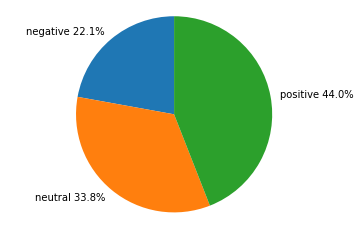

In [ ]:
pos_tweets = df[(df.sentiment == 'Positive')] 
neu_tweets = df[(df.sentiment == 'Neutral')]                                                                   
neg_tweets = df[(df.sentiment == 'Negative')]  

labels= 'negative %.1f%%' %(len(neg_tweets)*100/len(df.sentiment)), 'neutral %.1f%%' %(len(neu_tweets)*100/len(df.sentiment)), 'positive %.1f%%' %(len(pos_tweets)*100/len(df.sentiment))
sentiments = [len(neg_tweets)*100/len(df.sentiment), len(neu_tweets)*100/len(df.sentiment), len(pos_tweets)*100/len(df.sentiment)]
plt.pie(sentiments, labels=labels, startangle=90)

plt.axis('equal')
plt.show()

### Bar Chart of most Frequently Used Words Tweets

First plot the barchart to see what words are most frequently used. We can then manually delete the words that overlap with the keywords itself (ex tax and taxes for the keyword tax). 


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

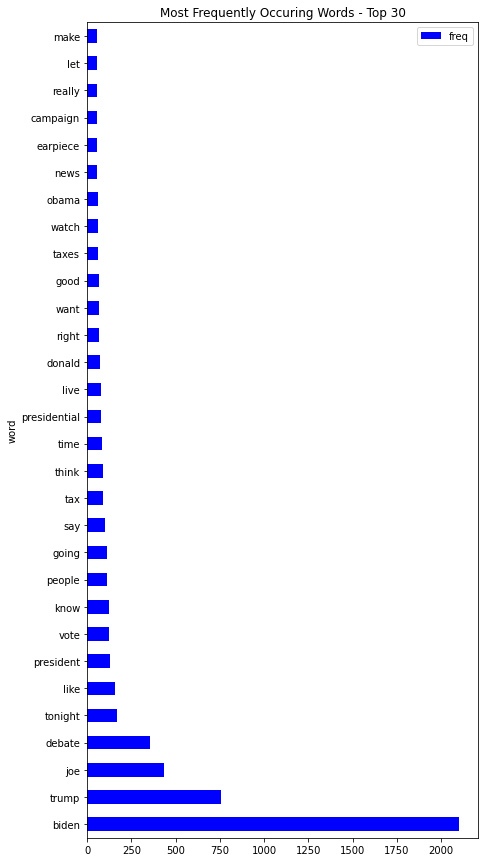

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(tokens_cl)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='barh', figsize=(7, 15), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

In [ ]:
# Remove repition with key words or if they are articles (ex: like)
del words_freq[:2]
frequency = frequency.iloc[2:]

Text(0.5, 1.0, 'Top 30 Most Frequently Occuring Words Race in America Debate 2')

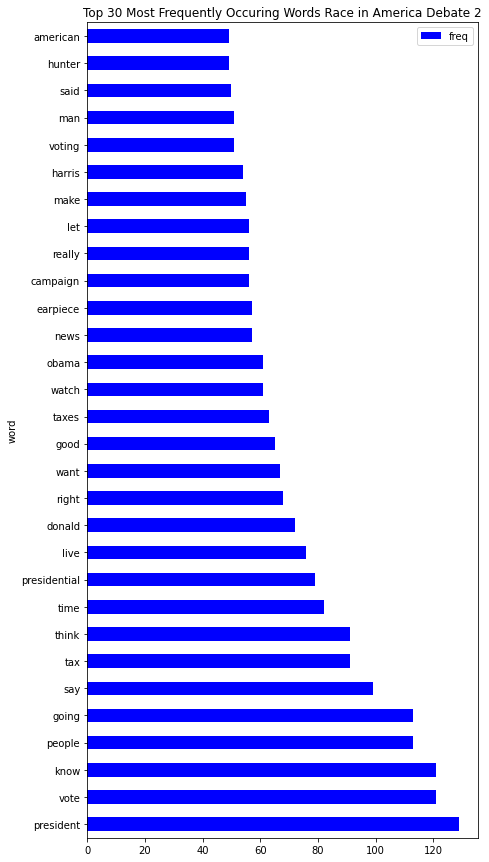

In [ ]:
frequency.head(30).plot(x='word', y='freq', kind='barh', figsize=(7, 15), color = 'blue')
plt.title("Top 30 Most Frequently Occuring Words Race in America Debate 2")

###Word Cloud of Most Frequently Used Words in Tweets

(-0.5, 999.5, 999.5, -0.5)

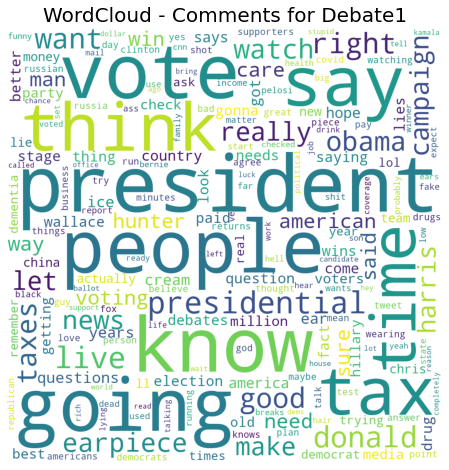

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Comments for Debate1", fontsize = 20)
plt.axis('off')

# Analysis of Tweets: Over Time
For this, we tried out using the Google Natural Language API to test out another sentiment tool. The code is the same for visualization but again, we will show how to set up another sentiment analysis tool for posterity. 

Again, you can change the dataset to the datasets of other keywords as above: 
 /dataset/debate_\*/search_results_\*.csv

In [ ]:
df_1 = pd.read_csv('/dataset/debate_1/National_Security.csv')
df_2 = pd.read_csv('/dataset/debate_2/National_Security.csv')

### Text Cleaning

We will clean the text by removing any punctuations. In addition, this steps also removes any twitter username (@username...) and websites link (http... and www...). The processes above are done using Regular Expression method to search for matching texts (as above)


In [ ]:
tokenizer = WordPunctTokenizer()
twitter_handle = r'@[A-Za-z0-9_]+'                         # remove twitter handle (@username)
url_handle = r'http[^ ]+'                                  # remove website URLs that start with 'https?://'
combined_handle = r'|'.join((twitter_handle, url_handle))  # join
www_handle = r'www.[^ ]+'                                  # remove website URLs that start with 'www.'
punctuation_handle = r'\W+'

In [ ]:
stop_word = set(pd.read_csv('/data/stopword_en.txt', sep = '\n', header =0).stopword)
#stop_word = set(pd.read_csv('/content/drive/MyDrive/Fall_2020/143/stopword_en.txt', sep = '\n', header =0).stopword)

def process_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()

    try:
        text = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        text = souped

    cleaned_text = re.sub(punctuation_handle, " ",(re.sub(www_handle, '', re.sub(combined_handle, '', text)).lower()))
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_word])

    return (" ".join([word for word in tokenizer.tokenize(cleaned_text) if len(word) > 1])).strip()

In [ ]:
cleaned_text_1 = []

for text in df_1.content:
    cleaned_text_1.append(process_text(text))

cleaned_text_1 = pd.DataFrame({'clean_text' : cleaned_text_1})
df_1 = pd.concat([df_1, cleaned_text_1], axis = 1)

In [ ]:
cleaned_text_2 = []

for text in df_2.content:
    cleaned_text_2.append(process_text(text))

cleaned_text_2 = pd.DataFrame({'clean_text' : cleaned_text_2})
df_2 = pd.concat([df_2, cleaned_text_2], axis = 1)

## Sentiment Analysis
Sentiment analysis attempts to determine the overall attitude (positive or negative) expressed within the text. Sentiment is represented by numerical score and magnitude values. Google Natural Language API takes the longest to return results. Can take the sentiment values from Vader and do the same plot in less time. It also requires authentication, which requires an account. This can be troublesome and a nuisance. 

Visualization code below is most important aspect but the sentiment analysis is kept to be thorough. 

**Score of the sentiment ** ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

**Magnitude** indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Unlike score, magnitude is not normalized; each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes).

In [ ]:
# Install TTS
!pip install --upgrade google-cloud-language
!pip install --upgrade setuptools

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (50.3.2)


In [ ]:
import argparse

# Imports the Google Cloud client library
from google.cloud import language_v1 
from google.cloud.language_v1.gapic import enums
from google.cloud.language_v1 import types

In [ ]:
!set GOOGLE_APPLICATION_CREDENTIALS="/content/drive/MyDrive/Fall_2020/143/Project-d866fe6693f1.json"
!gcloud auth activate-service-account --key-file /content/drive/MyDrive/Fall_2020/143/Project-d866fe6693f1.json

Activated service account credentials for: [election-sentiment@eminent-booking-297305.iam.gserviceaccount.com]


In [ ]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/Fall_2020/143/Project-d866fe6693f1.json"

In [ ]:
def create_sentiment_gcp(row):
    """Uses GCP Cloud NL to Create Sentiments on a DataFrame"""
    try:
      client = language_v1.LanguageServiceClient()
      document = language_v1.Document(content=row, type_=language_v1.Document.Type.PLAIN_TEXT)
      sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
      sentiment_score = sentiment.score
      #print("Text: {}".format(row))
      #print("Sentiment: {}, {}".format(sentiment.score, sentiment.magnitude))

    except Exception:
      print("Size exceeded:  Fail")
      return None
    return sentiment_score

def apply_sentiment_gcp(df, column="clean_text"):
    """Uses Pandas Apply to Create Sentiment Analysis"""

    df['Sentiment'] = df[column].apply(create_sentiment_gcp)
    return df

In [ ]:
tweet_d1 = apply_sentiment_gcp(df_1)

In [ ]:
tweet_d2 = apply_sentiment_gcp(df_2)

## Catergorize the Sentiments 


In [ ]:
def deter_positive(value):
  if value > 0:return 'positive'
  elif value == 0: return 'neutral'
  elif value < 0: return 'negative'
  
tweet_sentiment['Sentiment Normalized']=tweet_sentiment['Sentiment'].apply(lambda x:deter_positive(x))

## Compute Rolling Average and Adjust Time Zone

In [ ]:
#time diff to be adjusted for 
td = pd.to_timedelta(5, unit='h')

##from debate 1

tweet_sent_d1['date'] = pd.to_datetime(tweet_sent_d1['date'], format = '%Y-%m-%dT%H:%M:%S')
tweet_sent_d1['date'] = pd.to_datetime(tweet_sent_d1.date).dt.tz_localize(None)
d1_df = tweet_sent_d1.filter(['date','Sentiment'], axis = 1)

d1_df['rolling_avg'] = d1_df.Sentiment.rolling(20).mean()
d1_df['date'] = d1_df['date'].apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S') - td)
d1_df

,date,Sentiment,rolling_avg
0,2020-09-30 18:59:19,-0.7,NaN
1,2020-09-30 18:59:10,0.0,NaN
2,2020-09-30 18:59:09,-0.4,NaN
3,2020-09-30 18:58:53,0.6,NaN
4,2020-09-30 18:58:02,-0.7,NaN
...,...,...,...
6830,2020-09-29 19:00:23,0.0,-0.456
6831,2020-09-29 19:00:15,-0.1,-0.444
6832,2020-09-29 19:00:09,-0.7,-0.456
6833,2020-09-29 19:00:05,-0.7,-0.484


In [ ]:
##from debate 2
tweet_sent_d2['date'] = pd.to_datetime(tweet_sent_d2['date'], format = '%Y-%m-%dT%H:%M:%S')
tweet_sent_d2['date'] = pd.to_datetime(tweet_sent_d2.date).dt.tz_localize(None)
d2_df = tweet_sent_d2.filter(['date','Sentiment'], axis = 1)

d2_df['rolling_avg'] = d2_df.Sentiment.rolling(20).mean()
d2_df['date'] = d2_df['date'].apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S') - td)
d2_df

,date,Sentiment,rolling_avg
0,2020-10-23 18:59:15,-0.6,NaN
1,2020-10-23 18:58:31,-0.7,NaN
2,2020-10-23 18:57:28,0.2,NaN
3,2020-10-23 18:56:44,-0.3,NaN
4,2020-10-23 18:56:11,0.1,NaN
...,...,...,...
6244,2020-10-22 19:00:04,0.0,-0.308
6245,2020-10-22 19:00:01,0.0,-0.308
6246,2020-10-22 19:00:01,0.0,-0.340
6247,2020-10-22 19:00:00,-0.4,-0.328


## Moving Average of Sentiment of Tweets over Time

Notice not overlapped due to date difference. We must remove the date then apply an arbitruary date (today's date will do) and then plot to overlay the two timestamps. 

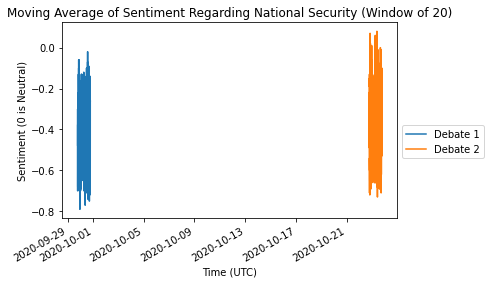

In [ ]:
x = d1_df['date']
y = d1_df['rolling_avg']

x2 = d2_df['date']
y2 = d2_df['rolling_avg']

fig, ax = plt.subplots()

ax.plot(x,y)
ax.plot(x2,y2)
plt.legend(['Debate 1', 'Debate 2'],
           loc='upper left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Moving Average of Sentiment Regarding National Security (Window of 20)')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Sentiment (0 is Neutral)')

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%m-%d %H:%M')

In [ ]:
import datetime
import matplotlib.dates as md

newnew_df = new_df
newnew_df['date'] = pd.to_datetime(newnew_df['date']).dt.time
dateobject = datetime.date.today()
x_dt = [0]*len(newnew_df['date'])
for i in range(len(newnew_df['date'])):
  x_dt[i] = datetime.datetime.combine(dateobject, newnew_df['date'][i])
y = new_df['rolling_avg']

result_df = rslt_df
result_df['date'] = pd.to_datetime(result_df['date']).dt.time
dateobject = datetime.date.today()
x2_dt = [0]*len(result_df['date'])
for i in range(len(result_df['date'])):
  x2_dt[i] = datetime.datetime.combine(dateobject, result_df['date'][i])
y2 = rslt_df['rolling_avg']

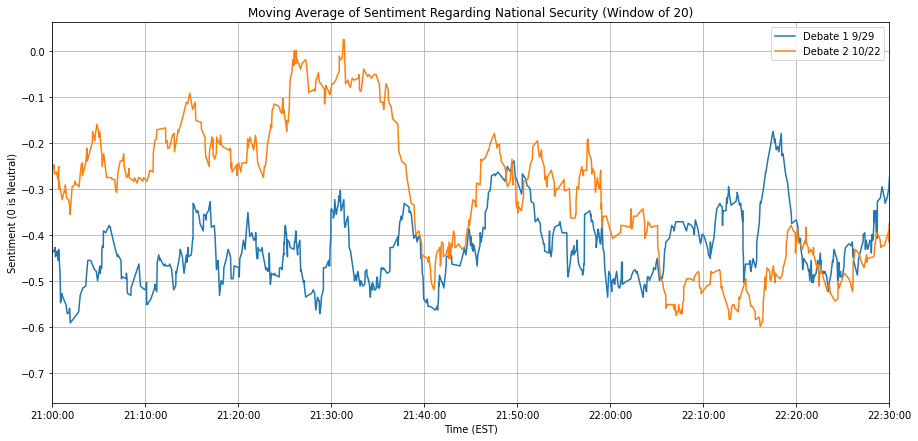

In [ ]:
current_date = datetime.date.today().strftime("%Y-%m-%d")
min = pd.Timestamp(current_date + ' 21:00:00')
max = pd.Timestamp(current_date + ' 22:30:00')

plt.figure(figsize=(15,7))
ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)

plt.plot(sorted(x_dt),y)
plt.plot(sorted(x2_dt),y2)
plt.xlim(min, max)
plt.legend(['Debate 1 9/29', 'Debate 2 10/22'],
           loc='upper right')
plt.title('Moving Average of Sentiment Regarding National Security (Window of 20)')
plt.xlabel('Time (EST)')
plt.ylabel('Sentiment (0 is Neutral)')
plt.grid()
plt.show()